In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from lib.items import Item
from lib.loaders import ItemLoader
from lib.utils import report, test_price_tokenization
import random
from collections import Counter, defaultdict
import numpy as np
import pickle
from transformers import AutoTokenizer
from collections import Counter
%matplotlib inline

# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
%cd ../..
project_folder = Path("AI/deals_agents")
preprocessed_data = project_folder/"output"/"preprocessed_data"

/home/hien/Work


# EDA

In [3]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full",
                       trust_remote_code=True)

In [4]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [5]:
# Investigate a particular datapoint
datapoint = dataset[5]

In [6]:
# Investigate

print("Item's title: ", datapoint["title"])
print("Item's description: ", datapoint["description"])
print("Item's features: ", datapoint["features"])
print("Item's details: ", datapoint["details"])
print("Item's price: ", datapoint["price"])

Item's title:  1841N030 - Brown Aftermarket Replacement Stove Range Oven Drip Bowl Pan
Item's description:  ['This is a Brand New Aftermarket Replacement Drip Bowl Pan']
Item's features:  ['This is a Brand New Aftermarket Replacement Drip Bowl Pan', 'Top Qualty Aftermarket Replacement Part!']
Item's details:  {"Manufacturer": "Universal", "Part Number": "1841N030", "Item Weight": "3 ounces", "Product Dimensions": "6 x 6 x 6 inches", "Item model number": "CECOMINOD023154", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1181026, "Range Replacement Drip Pans": 613}, "Date First Available": "November 19, 2013"}
Item's price:  None


In [7]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [8]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

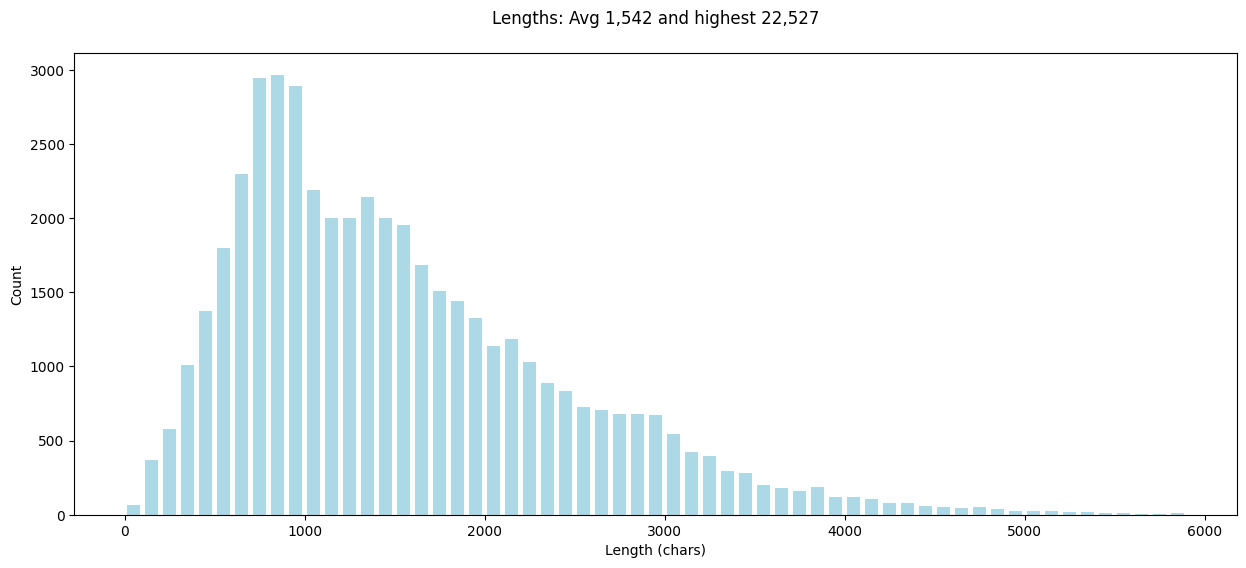

In [9]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

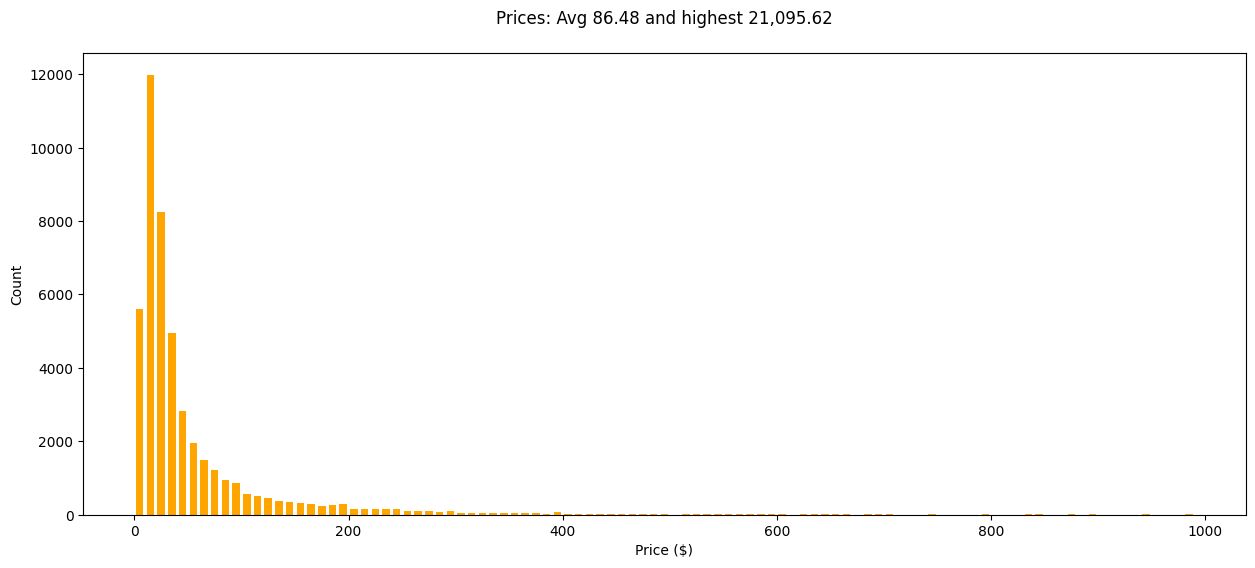

In [10]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

# Data Preparation

In [11]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [12]:
# Look at the first item

items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [13]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [14]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


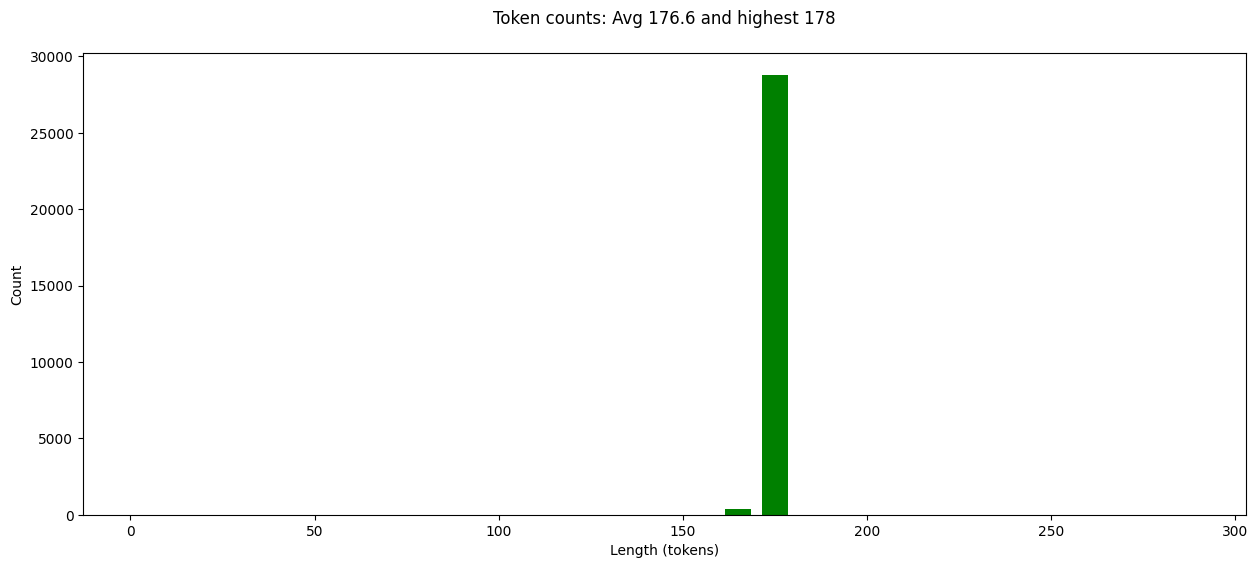

In [15]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

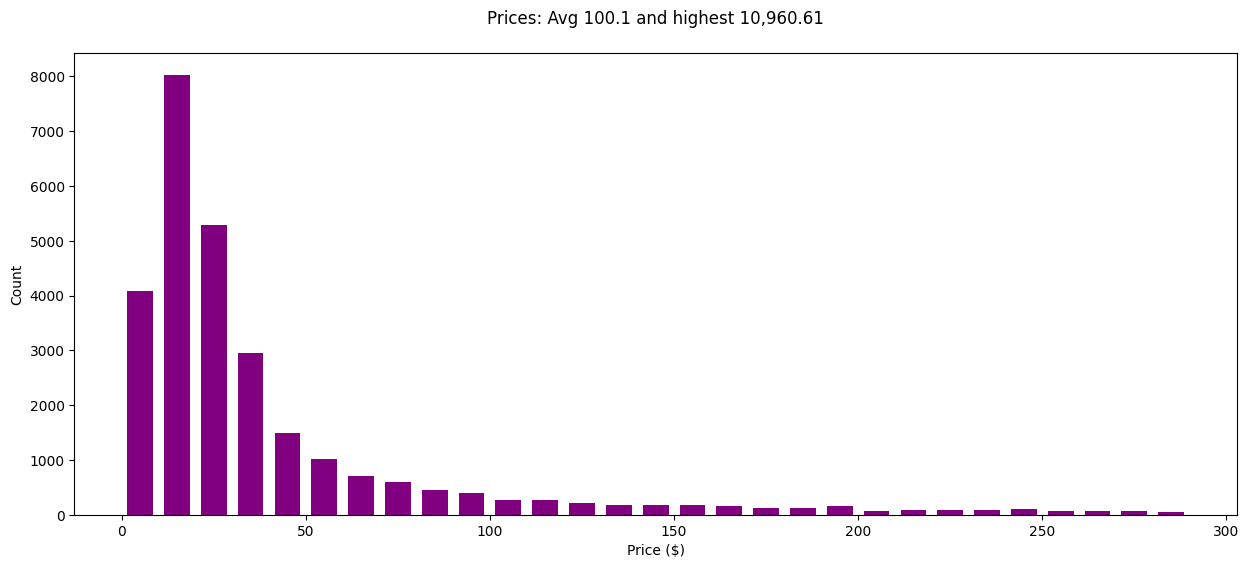

In [16]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

## Small Dataset

In [17]:
# Only select items price under $999
items = []
for dataset_name in ["Appliances", "Electronics", "Toys_and_Games", "Musical_Instruments"]:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Completed Appliances with 28,625 datapoints in 0.1 mins
Loading dataset Electronics



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The

Completed Electronics with 443,473 datapoints in 1.0 mins
Loading dataset Toys_and_Games



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The

Completed Toys_and_Games with 340,479 datapoints in 0.6 mins
Loading dataset Musical_Instruments



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The

Completed Musical_Instruments with 66,829 datapoints in 0.2 mins


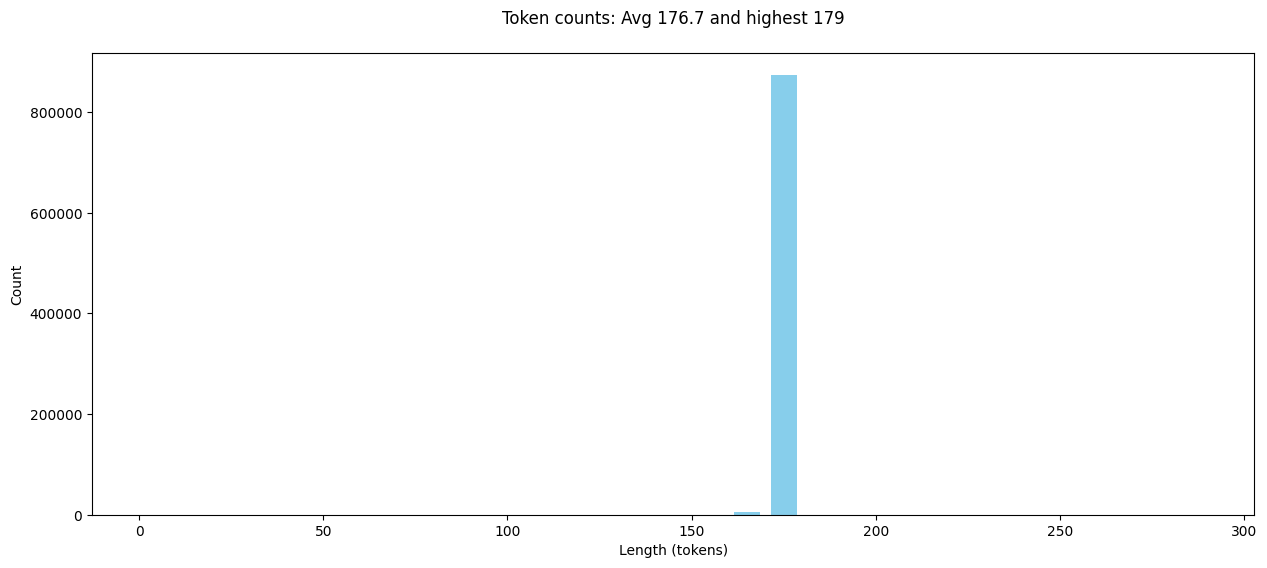

In [18]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

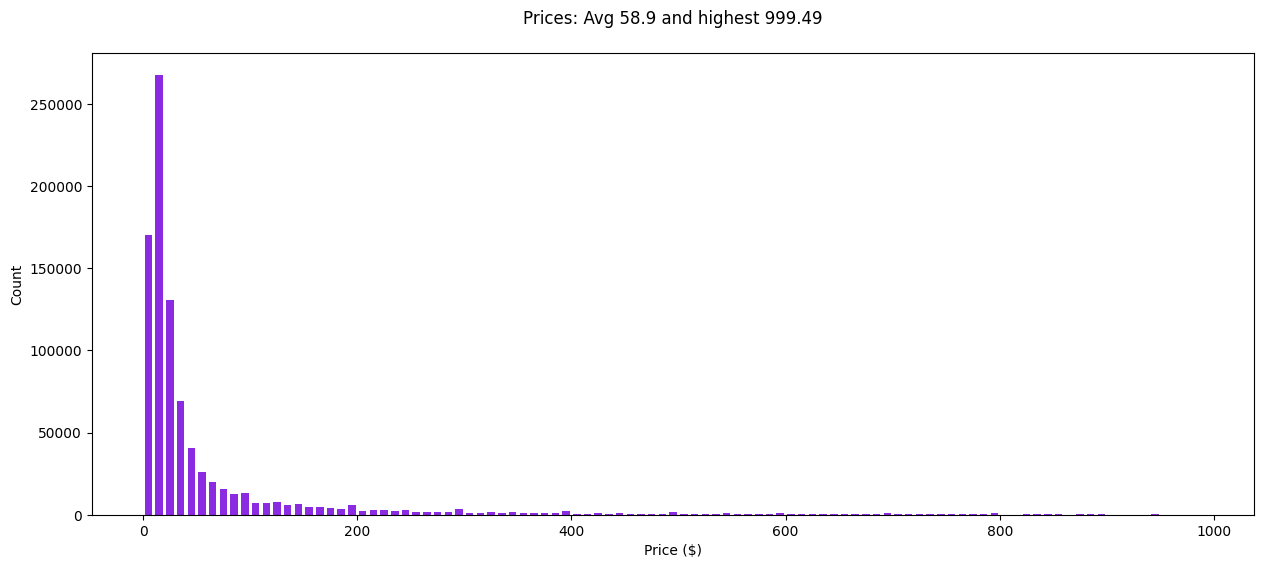

In [19]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

## Visualization

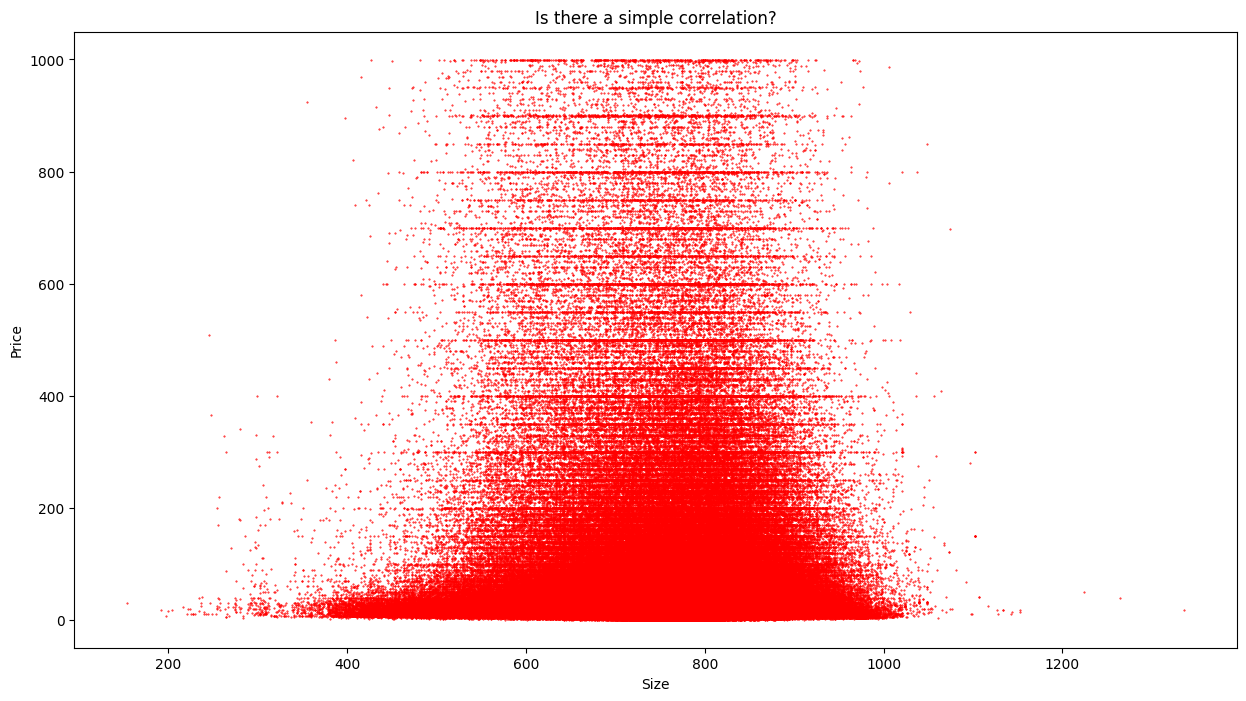

In [20]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [21]:
report(sample[50])

## FULL PROMPT (WHAT THE MODEL SEES) ##
How much does this cost to the nearest dollar?

285746 OR 285811 Washer Agitator Support And Dogs Compatible with Inglis, Whirlpool, Kenmore, Roper, Admiral
285746 OR 285811 Agitator support and dogs Washing machine agitator repair kit with a medium length cam Agitator support and dogs for two piece agitators.This kit should be used when the top part of the agitator is not moving properly but the bottom part is. Replaces Old Numbers 2744 285746 285811 Washer Agitator Repair Kit. This part works with the following brands Whirlpool, Roper, Admiral, Maytag, Hardwick, Jenn-Air, Estate, Magic Chef, Crosley, Inglis, Norge, Modern Maid, Amana, Kenmore

Price is $8.00
## PRICE DECODING CRITICAL SECTION ##
Last 10 tokens (IDs): [11, 14594, 6518, 271, 7117, 374, 400, 23, 13, 410]
## Decoded tokens ##
[',', ' Ken', 'more', '\n\n', 'Price', ' is', ' $', '8', '.', '00']


## Full Dataset

In [4]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [ ]:
big_items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


100%|██████████| 2004/2004 [01:33<00:00, 21.34it/s]


Completed Automotive with 911,688 datapoints in 1.7 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [00:55<00:00, 28.89it/s]

Completed Electronics with 443,473 datapoints in 1.0 mins
Loading dataset Office_Products



100%|██████████| 711/711 [00:24<00:00, 28.95it/s]

Completed Office_Products with 240,394 datapoints in 0.5 mins
Loading dataset Tools_and_Home_Improvement



100%|██████████| 1474/1474 [00:58<00:00, 25.25it/s]

Completed Tools_and_Home_Improvement with 541,051 datapoints in 1.1 mins
Loading dataset Cell_Phones_and_Accessories



100%|██████████| 1289/1289 [00:35<00:00, 36.01it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 0.7 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [00:35<00:00, 24.92it/s]

Completed Toys_and_Games with 340,479 datapoints in 0.7 mins
Loading dataset Appliances



100%|██████████| 95/95 [00:03<00:00, 25.68it/s]


Completed Appliances with 28,625 datapoints in 0.1 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [00:06<00:00, 30.70it/s]


Completed Musical_Instruments with 66,829 datapoints in 0.2 mins


In [ ]:
print(f"A grand total of {len(big_items):,} items")

A grand total of 2,811,408 items


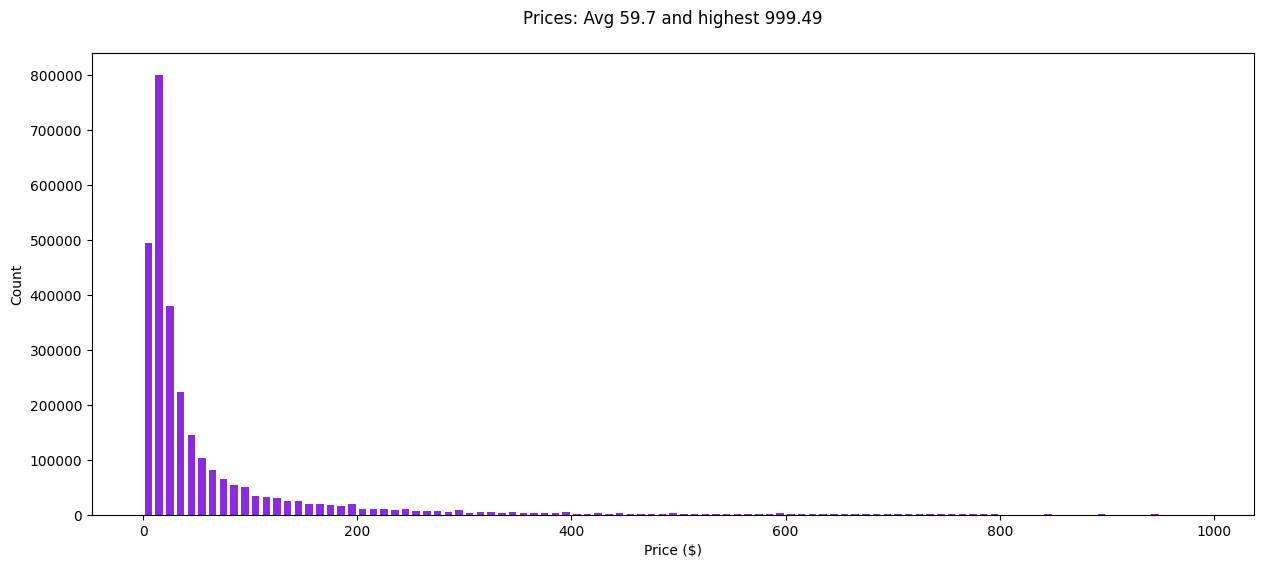

In [ ]:
# Plot the distribution of prices

prices = [item.price for item in big_items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

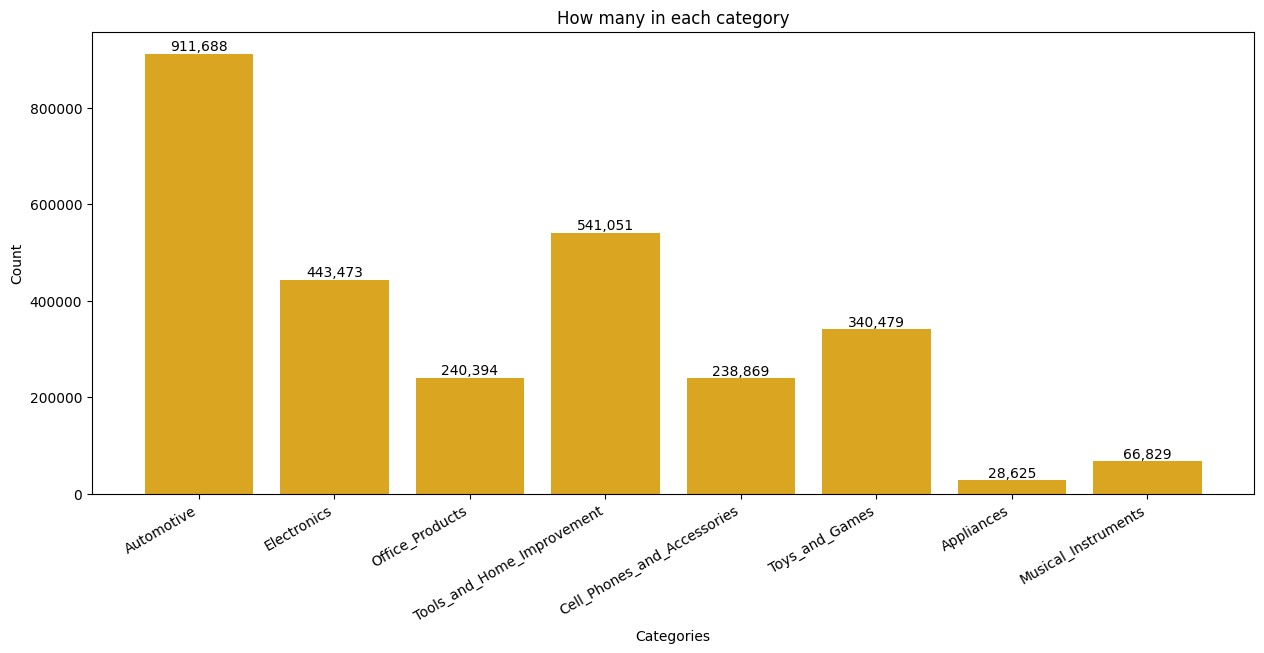

In [ ]:
category_counts = Counter()
for item in big_items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [ ]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in big_items:
    slots[round(item.price)].append(item)

# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

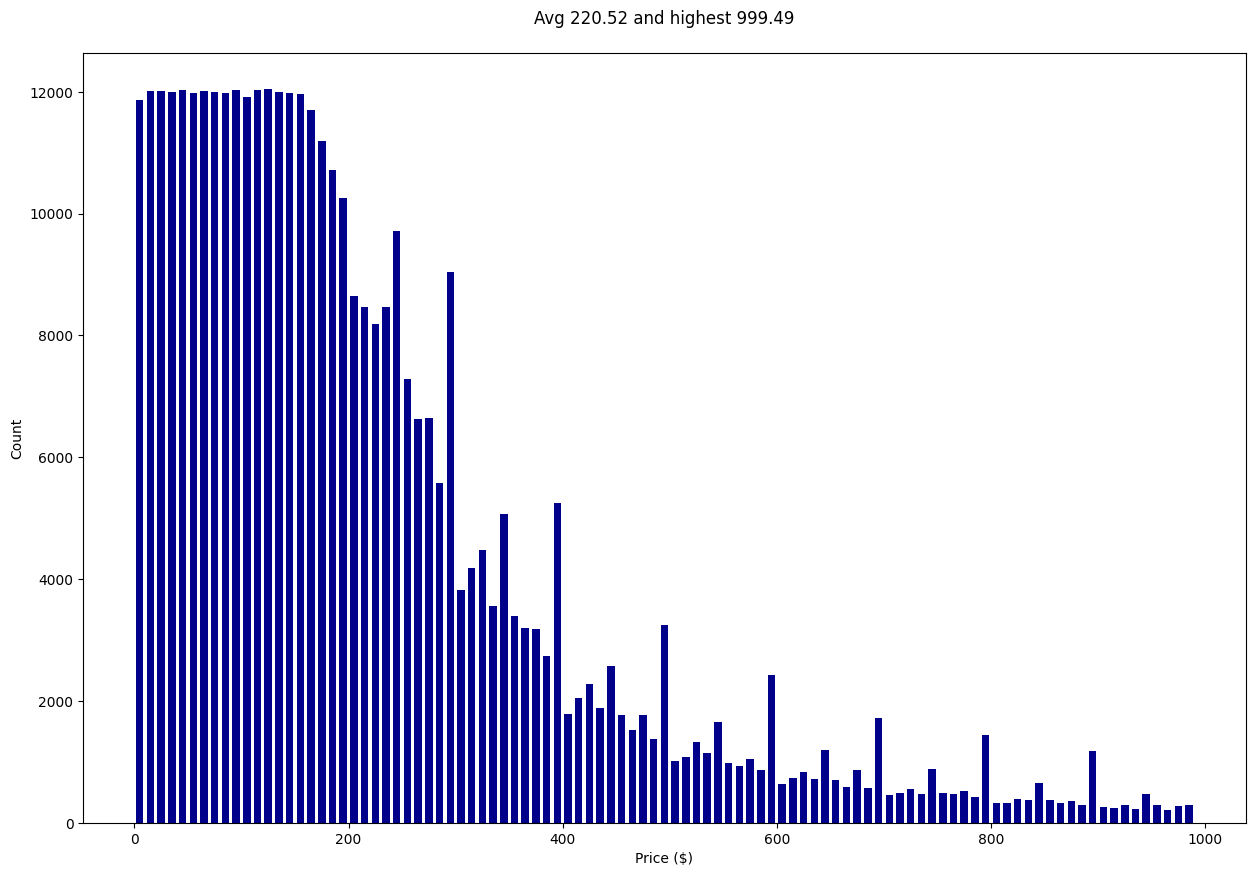

In [11]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

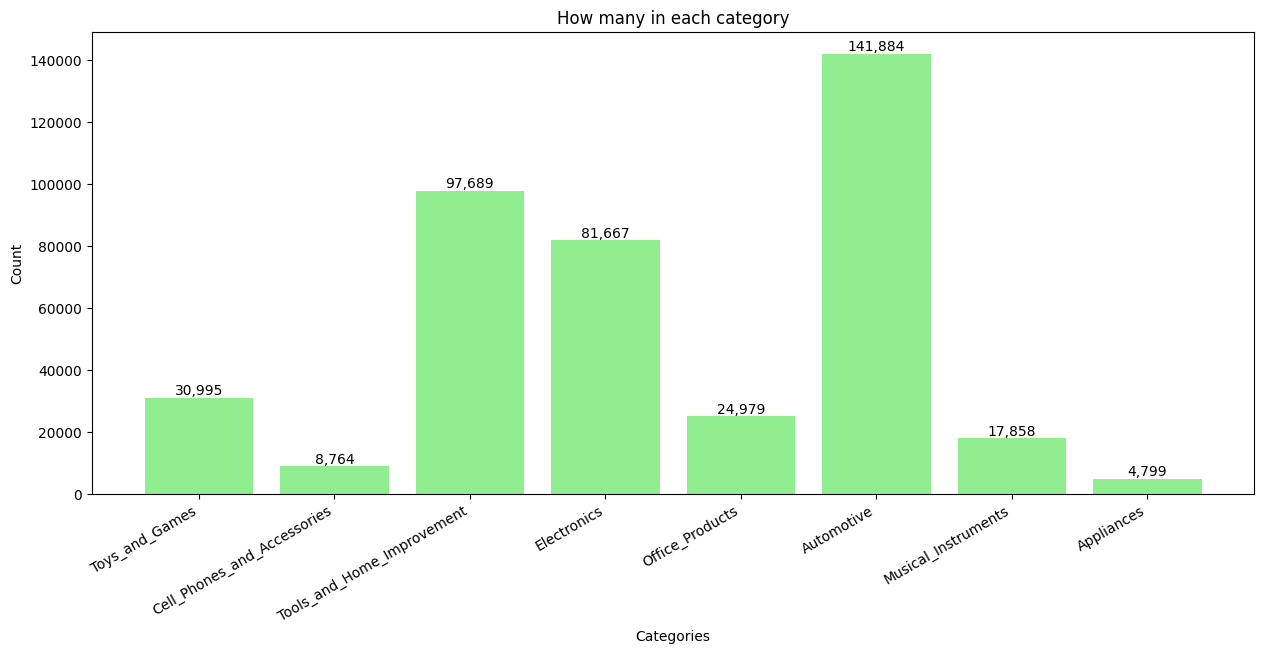

In [12]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Train Test Split

## Small Dataset

In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [ ]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [ ]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


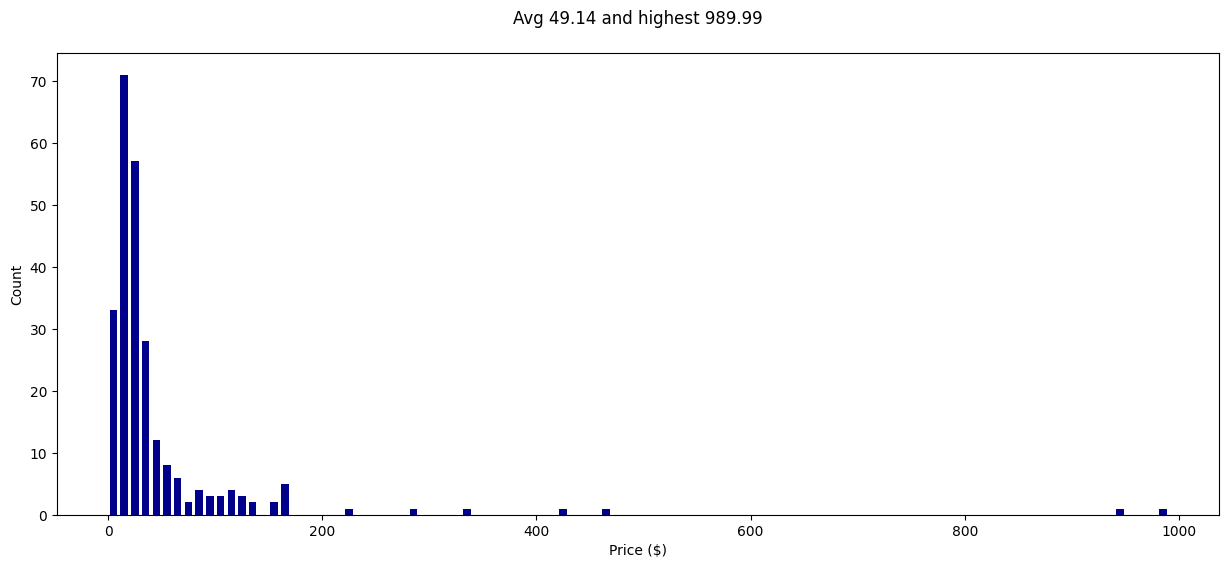

In [ ]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [ ]:
# Count price frequencies
price_counts = Counter(round(item.price) for item in train)

# Get top 10 most common prices
most_common = price_counts.most_common(10)
print("Most frequent prices:")
for price, count in most_common:
    print(f"${price}: {count} items")

# Get bottom 10 least common prices
least_common = price_counts.most_common()[-10:]
print("\nLeast frequent prices:")
for price, count in least_common:
    print(f"${price}: {count} items")

# Total unique prices
print(f"\nUnique prices: {len(price_counts)}")

Most frequent prices:
$10: 1113 items
$20: 862 items
$12: 841 items
$8: 746 items
$13: 728 items
$11: 706 items
$9: 705 items
$15: 681 items
$17: 659 items
$14: 634 items

Least frequent prices:
$996: 1 items
$536: 1 items
$663: 1 items
$914: 1 items
$381: 1 items
$778: 1 items
$818: 1 items
$970: 1 items
$433: 1 items
$593: 1 items

Unique prices: 645


In [ ]:
# Load tokenizer with authentication

tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Meta-Llama-3.1-8B",
    token=hf_token,
    trust_remote_code=True
)

# Test tokenization
results = {}
for i in range(len(train)):
    item = train[i]
    price_int = round(item.price)  # Get the integer price
    # Test tokenization for this single price
    results[price_int] = test_price_tokenization(tokenizer, price_int)

# Analyze results
single_token_prices = [p for p, is_single in results.items() if is_single]
multi_token_prices = [p for p, is_single in results.items() if not is_single]

print(f"Single-token prices: {len(single_token_prices)}/{len(results)}")
print(f"Multi-token prices: {len(multi_token_prices)}/{len(results)}")
print("Examples of multi-token prices:", multi_token_prices[:10])


Single-token prices: 645/645
Multi-token prices: 0/645
Examples of multi-token prices: []


In [ ]:
# Verify how prices appear in actual prompts
for i in range(min(5, len(train))):
    item = train[i]  # Get the Item object
    prompt = item.prompt  # Access the prompt attribute directly
    tokens = tokenizer.tokenize(prompt)

    print(f"\nPrompt {i+1} ending tokens:")
    # Show last 5 tokens where price appears
    print(tokens[-5:])

    # Check if price is tokenized correctly
    price_str = str(round(item.price))
    price_tokens = tokenizer.tokenize(price_str)

    if len(price_tokens) > 1:
        print(f"⚠️ Price {price_str} splits into {len(price_tokens)} tokens: {price_tokens}")
    else:
        print(f"✅ Price {price_str} → single token: {price_tokens[0]}")



Prompt 1 ending tokens:
['Ġis', 'Ġ$', '12', '.', '00']
✅ Price 12 → single token: 12

Prompt 2 ending tokens:
['Ġis', 'Ġ$', '261', '.', '00']
✅ Price 261 → single token: 261

Prompt 3 ending tokens:
['Ġis', 'Ġ$', '85', '.', '00']
✅ Price 85 → single token: 85

Prompt 4 ending tokens:
['Ġis', 'Ġ$', '15', '.', '00']
✅ Price 15 → single token: 15

Prompt 5 ending tokens:
['Ġis', 'Ġ$', '22', '.', '00']
✅ Price 22 → single token: 22


## Full Dataset

In [15]:
random.seed(42)
random.shuffle(sample)
big_train = sample[:400000]
big_test = sample[400000:402000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


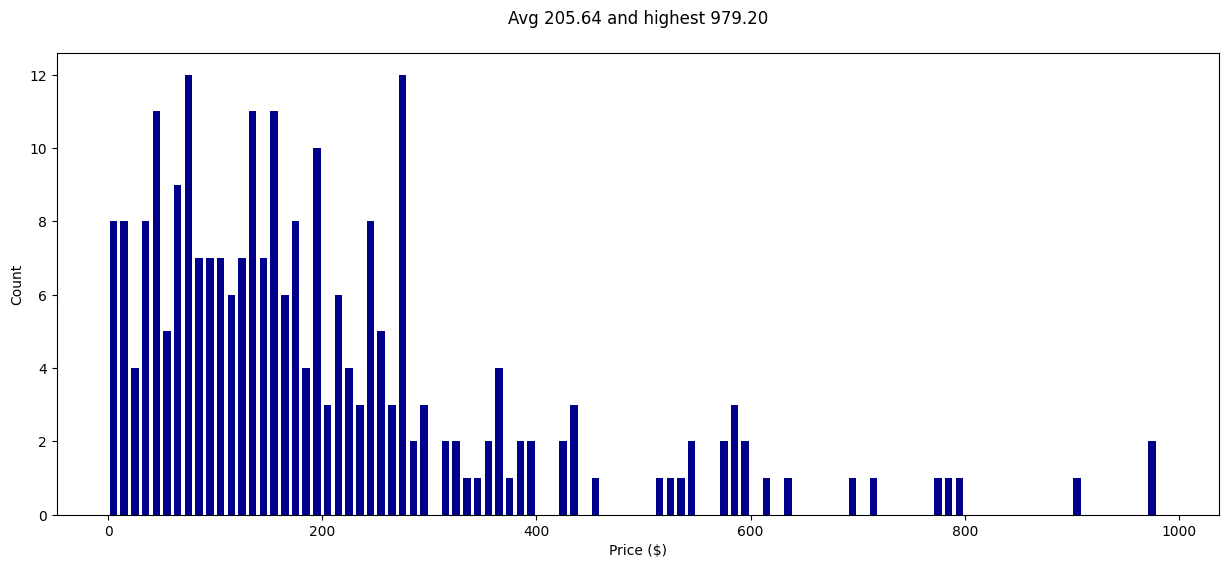

In [16]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in big_test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# HuggingFace Dataset Uploading

## Small Dataset

In [ ]:
# Convert to prompts and upload to HuggingFace hub

train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [ ]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
DATASET_NAME = "hiennguyen231191/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/hiennguyen231191/lite-data/commit/996e171cd68c8d3534fb2200bde01cd29366d149', commit_message='Upload dataset', commit_description='', oid='996e171cd68c8d3534fb2200bde01cd29366d149', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/hiennguyen231191/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='hiennguyen231191/lite-data'), pr_revision=None, pr_num=None)

In [ ]:
with open(preprocessed_data/'train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open(preprocessed_data/'test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

## Full Dataset

In [17]:
train_prompts = [item.prompt for item in big_train]
train_prices = [item.price for item in big_train]
test_prompts = [item.test_prompt() for item in big_test]
test_prices = [item.price for item in big_test]

In [20]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [21]:
DATASET_NAME = "hiennguyen231191/large-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/hiennguyen231191/large-data/commit/34822cfeefdd853e5293f58a5aa0f6288a2b642a', commit_message='Upload dataset', commit_description='', oid='34822cfeefdd853e5293f58a5aa0f6288a2b642a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/hiennguyen231191/large-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='hiennguyen231191/large-data'), pr_revision=None, pr_num=None)

In [23]:
with open(preprocessed_data/'train.pkl', 'wb') as file:
    pickle.dump(big_train, file)

with open(preprocessed_data/'test.pkl', 'wb') as file:
    pickle.dump(big_test, file)